In [4]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.applications import inception_resnet_v2
#from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from keras import regularizers

In [6]:
datagen_train = ImageDataGenerator(
    rescale=1./255,
      rotation_range=180,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=[0.9, 1.5],
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

In [7]:
path = '/home/jgomez/Documents/Us'

In [8]:
train_dir = path + "/train"
test_dir = path+"/val"

In [9]:
batch_size = 8
img_height = 224
img_width = 224

In [10]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, ZeroPadding2D
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

def create_model():
    
    def add_conv_block(model):
        model.add(Conv2D(96, 11, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=2))
        model.add(Conv2D(256, 5, activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=2))
        model.add(ZeroPadding2D((1, 1)))
        model.add(Conv2D(512, 3, activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=2))
        model.add(ZeroPadding2D((1, 1)))
        model.add(Conv2D(1024, 3, activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(ZeroPadding2D((1, 1)))
        model.add(Conv2D(1024, 3, activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(3072, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        model.add(Dense(4096, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        model.add(Dense(4608, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        model.add(Dense(2))
        return model
    
    model = tf.keras.models.Sequential()
    model.add(Input(shape=(56, 56, 3)))
    model = add_conv_block(model)
    

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 56, 56, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 56, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 16, 16, 256)       0

In [11]:
input_shape = model.layers[0].output_shape[1:3]
input_shape

(56, 56)

In [12]:
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True)

Found 45646 images belonging to 2 classes.


In [13]:
datagen_test = ImageDataGenerator(rescale=1./255)

In [14]:
generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)

Found 1194 images belonging to 2 classes.


In [15]:
h = model.fit(
    generator_train,
    validation_data=generator_test,
    epochs=50, 
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15),
        tf.keras.callbacks.ModelCheckpoint('models/model_{val_accuracy:.3f}.h5', save_best_only=True,
                                          save_weights_only=False, monitor='val_accuracy')
    ]
)

Epoch 1/50
5706/5706 [==============================] - 2933s 514ms/step - loss: 1.3238 - accuracy: 0.4998 - val_loss: 0.9314 - val_accuracy: 0.5126
Epoch 2/50
5706/5706 [==============================] - 2908s 510ms/step - loss: 0.8704 - accuracy: 0.4978 - val_loss: 1.2068 - val_accuracy: 0.5000
Epoch 3/50
5706/5706 [==============================] - 2924s 512ms/step - loss: 1.0623 - accuracy: 0.5026 - val_loss: 0.9713 - val_accuracy: 0.4841
Epoch 4/50
5706/5706 [==============================] - 2926s 513ms/step - loss: 1.0890 - accuracy: 0.5028 - val_loss: 0.9684 - val_accuracy: 0.4816
Epoch 5/50
5706/5706 [==============================] - 2936s 514ms/step - loss: 0.9819 - accuracy: 0.4909 - val_loss: 0.9478 - val_accuracy: 0.5067
Epoch 6/50
5706/5706 [==============================] - 2938s 515ms/step - loss: 0.9650 - accuracy: 0.5050 - val_loss: 0.9974 - val_accuracy: 0.5050
Epoch 7/50
5706/5706 [==============================] - 2943s 516ms/step - loss: 0.9547 - accuracy: 0.4999

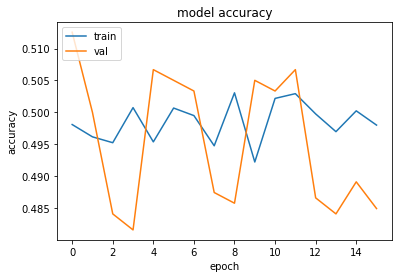

In [16]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

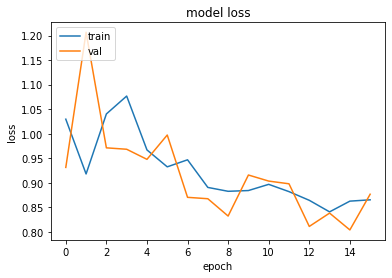

In [18]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()